# Feature Selection/Engineering


## Imports


In [187]:
from functions import *

## Preliminary Study


Reads the dataset and displays some examples


In [188]:
features_train = read_ds_gzip(
    Path(os.path.abspath("../in-star-craft-2-player")) / "TRAIN.CSV.GZ",
    ds="TRAIN",
)

features_train.tail(3)

,battleneturl,played_race,0,1,2,3,4,5,6,7,...,10527,10528,10529,10530,10531,10532,10533,10534,10535,10536
3049,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,hotkey50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3050,http://xx.battle.net/sc2/en/profile/410/1/STBo...,Terran,s,s,hotkey10,s,hotkey20,s,s,hotkey12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3051,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,hotkey50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset is **imbalanced** in terms of **class** (URLs)...


[]

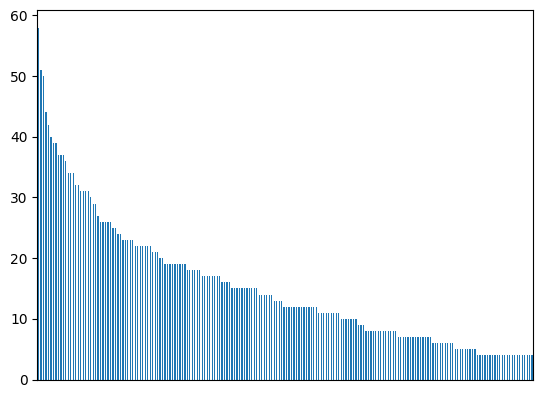

In [189]:
battlenet_count_serie = features_train["battleneturl"].value_counts()
battlenet_count_serie.plot.bar().axes.get_xaxis().set_ticks([])

... but also in terms of **played races**.


<Axes: ylabel='played_race'>

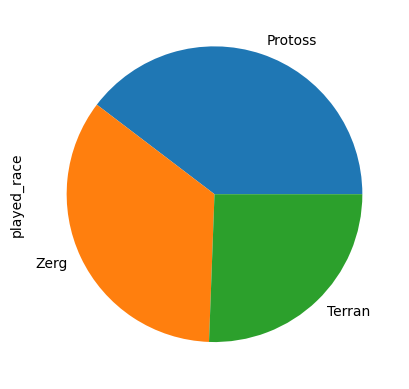

In [190]:
playedrace_count_serie = features_train["played_race"].value_counts()
playedrace_count_serie.plot.pie()

## Adding features and further processing


Adding the **number of actions done** (including time steps), the **game duration** and the **mean number of actions per second** (including time steps) of each entry.


In [191]:
features_train["first_nan_index"] = features_train.apply(
    first_nan_occurrence, axis=1
)  # need to remove tX in this count
features_train["max_t_value"] = features_train.apply(max_t_value, axis=1)

features_train["first_nan_index"] = pd.to_numeric(
    features_train["first_nan_index"], errors="coerce"
)

features_train["action_per_sec"] = (
    features_train["first_nan_index"] / features_train["max_t_value"]
)

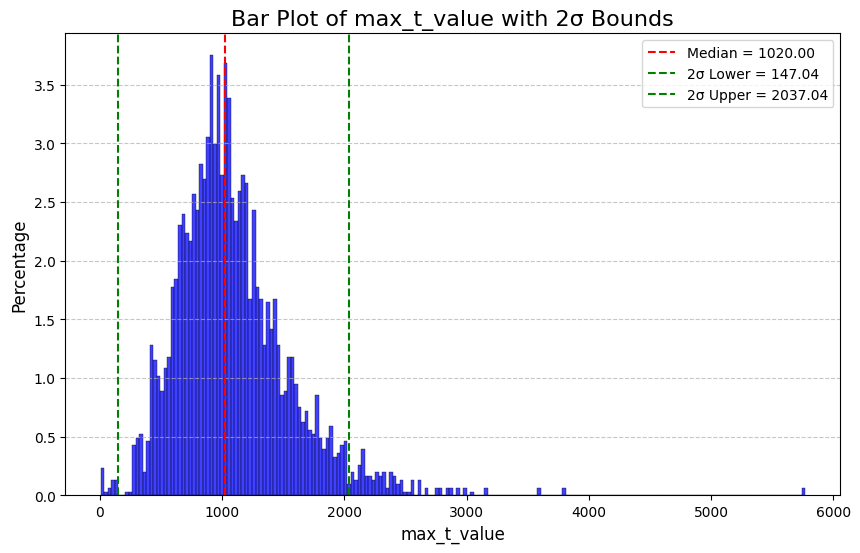

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

data = features_train["max_t_value"].dropna()
mean = data.mean()
std = data.std()
median = data.median()
lower_bound = max(0, mean - 2 * std)
upper_bound = mean + 2 * std

plt.figure(figsize=(10, 6))
sns.histplot(data, bins=200, kde=False, color="blue", stat="percent")
plt.axvline(median, color="red", linestyle="--", label=f"Median = {median:.2f}")
plt.axvline(
    lower_bound, color="green", linestyle="--", label=f"2σ Lower = {lower_bound:.2f}"
)
plt.axvline(
    upper_bound, color="green", linestyle="--", label=f"2σ Upper = {upper_bound:.2f}"
)

plt.title("Bar Plot of max_t_value with 2σ Bounds", fontsize=16)
plt.xlabel("max_t_value", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


**We remove the games that did not last much time**, because they can be considered as **"AFK" games**.


In [193]:
data = features_train["max_t_value"].dropna()

d_mean = data.mean()
median = data.median()
std = data.std()

lower_bound = max(d_mean - 2 * std, 0)
upper_bound = max(features_train["max_t_value"])

filtered_features_train = features_train[
    features_train["max_t_value"].between(lower_bound, upper_bound)
]

We turn the **played races to one hot encoding**.


In [194]:
filtered_features_train["played_protoss"] = (
    filtered_features_train["played_race"] == "Protoss"
).astype(int)
filtered_features_train["played_terran"] = (
    filtered_features_train["played_race"] == "Terran"
).astype(int)
filtered_features_train["played_zerg"] = (
    filtered_features_train["played_race"] == "Zerg"
).astype(int)

filtered_features_train = filtered_features_train.drop(columns=["played_race"])

/var/folders/m_/717x69rd7nz8wyvtvlgk_rlm0000gn/T/ipykernel_26820/925400731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features_train["played_protoss"] = (
/var/folders/m_/717x69rd7nz8wyvtvlgk_rlm0000gn/T/ipykernel_26820/925400731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features_train["played_terran"] = (
/var/folders/m_/717x69rd7nz8wyvtvlgk_rlm0000gn/T/ipykernel_26820/925400731.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Computing **creation, update, and use (total and hotkey wise), base selections, mineral and other per second**


In [195]:
patterns = {
    "total_creation_hotkeys_count_per_sec": r"hotkey\d+0",
    "creation_hotkey_1": r"hotkey10",
    "creation_hotkey_2": r"hotkey20",
    "creation_hotkey_3": r"hotkey30",
    "creation_hotkey_4": r"hotkey40",
    "creation_hotkey_5": r"hotkey50",
    "creation_hotkey_6": r"hotkey60",
    "creation_hotkey_7": r"hotkey70",
    "creation_hotkey_8": r"hotkey80",
    "creation_hotkey_9": r"hotkey90",
    "creation_hotkey_0": r"hotkey00",
    "total_update_hotkeys_count_per_sec": r"hotkey\d+1",
    "update_hotkey_1": r"hotkey11",
    "update_hotkey_2": r"hotkey21",
    "update_hotkey_3": r"hotkey31",
    "update_hotkey_4": r"hotkey41",
    "update_hotkey_5": r"hotkey51",
    "update_hotkey_6": r"hotkey61",
    "update_hotkey_7": r"hotkey71",
    "update_hotkey_8": r"hotkey81",
    "update_hotkey_9": r"hotkey91",
    "update_hotkey_0": r"hotkey01",
    "total_use_hotkeys_count_per_sec": r"hotkey\d+2",
    "use_hotkey_1": r"hotkey12",
    "use_hotkey_2": r"hotkey22",
    "use_hotkey_3": r"hotkey32",
    "use_hotkey_4": r"hotkey42",
    "use_hotkey_5": r"hotkey52",
    "use_hotkey_6": r"hotkey62",
    "use_hotkey_7": r"hotkey72",
    "use_hotkey_8": r"hotkey82",
    "use_hotkey_9": r"hotkey92",
    "use_hotkey_0": r"hotkey02",
    "s_per_sec": r"\bs\b",
    "base_per_sec": r"\bBase\b",
    "mineral_per_sec": r"\SingleMineral\b",
}

for column, pattern in patterns.items():
    filtered_features_train[column] = filtered_features_train.apply(
        lambda row: count_hotkeys(row, pattern), axis=1
    )

filtered_features_train


,battleneturl,0,1,2,3,4,5,6,7,8,...,use_hotkey_4,use_hotkey_5,use_hotkey_6,use_hotkey_7,use_hotkey_8,use_hotkey_9,use_hotkey_0,s_per_sec,base_per_sec,mineral_per_sec
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Base,s,s,s,s,s,t5,Base,s,...,0.154079,0.068882,0.010876,0.000000,0.000000,0.000000,0.024773,0.407251,0.039879,0.003021
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,s,Base,s,s,Base,s,s,Base,s,...,0.186103,0.000000,0.000000,0.000000,0.009668,0.010876,0.050151,0.325076,0.007251,0.000000
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Base,s,s,s,Base,s,hotkey30,hotkey00,t5,...,0.128713,0.087129,0.010891,0.000000,0.000000,0.001980,0.017822,0.425743,0.046535,0.002970
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Base,s,s,Base,s,s,s,t5,Base,...,0.282587,0.000000,0.000000,0.000000,0.000000,0.013930,0.038806,0.395025,0.020896,0.000000
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Base,s,s,s,Base,s,hotkey30,hotkey00,t5,...,0.155556,0.025926,0.000000,0.000000,0.000000,0.000000,0.000000,0.385185,0.003704,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,http://xx.battle.net/sc2/en/profile/405/1/MMA/,s,s,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,...,0.488636,0.248864,0.027273,0.000000,0.000000,0.000000,0.020455,0.650000,0.000000,0.004545
3048,http://xx.battle.net/sc2/en/profile/410/1/STBo...,s,s,hotkey10,s,hotkey20,s,s,hotkey12,hotkey22,...,0.234894,0.100426,0.125957,0.057021,0.011064,0.000000,0.000000,0.659574,0.000000,0.024681
3049,http://xx.battle.net/sc2/en/profile/405/1/MMA/,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,hotkey50,hotkey60,...,0.528205,0.249573,0.010256,0.000000,0.000000,0.000000,0.059829,0.769231,0.000000,0.004274
3050,http://xx.battle.net/sc2/en/profile/410/1/STBo...,s,s,hotkey10,s,hotkey20,s,s,hotkey12,hotkey22,...,0.181034,0.077586,0.063793,0.027586,0.000000,0.000000,0.000000,0.779310,0.000000,0.072414


The **behavior of a player** is defined especially by the **very first actions done**, so **we count the number of actions done before t=5,10,30 seconds**. Also, the **maximum number of actions done between two consecutive times** denote a certain **speed of the player**, also caracteristical. This discriminates the best player. In the same idea of discriminating good from bad players, we compute the **minimum of actions done between two consecutive times**.


In [196]:
filtered_features_train["actions_before_t5"] = filtered_features_train.iloc[
    :, 1:
].apply(lambda x: count_actions_before_t(x, "t5"), axis=1)

filtered_features_train["actions_before_t10"] = filtered_features_train.iloc[
    :, 1:
].apply(lambda x: count_actions_before_t(x, "t10"), axis=1)

filtered_features_train["actions_before_t30"] = filtered_features_train.iloc[
    :, 1:
].apply(lambda x: count_actions_before_t(x, "t30"), axis=1)


filtered_features_train["max_actions_between_t"] = filtered_features_train.iloc[
    :, 1:
].apply(max_actions_between_t, axis=1)

filtered_features_train["min_actions_between_t"] = filtered_features_train.iloc[
    :, 1:
].apply(min_actions_between_t, axis=1)

filtered_features_train.tail(3)

,battleneturl,0,1,2,3,4,5,6,7,8,...,use_hotkey_9,use_hotkey_0,s_per_sec,base_per_sec,mineral_per_sec,actions_before_t5,actions_before_t10,actions_before_t30,max_actions_between_t,min_actions_between_t
3049,http://xx.battle.net/sc2/en/profile/405/1/MMA/,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,hotkey50,hotkey60,...,0.0,0.059829,0.769231,0.0,0.004274,12,25,79,28,1
3050,http://xx.battle.net/sc2/en/profile/410/1/STBo...,s,s,hotkey10,s,hotkey20,s,s,hotkey12,hotkey22,...,0.0,0.000000,0.779310,0.0,0.072414,22,52,180,43,4
3051,http://xx.battle.net/sc2/en/profile/405/1/MMA/,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,hotkey50,hotkey60,...,0.0,0.000000,0.678632,0.0,0.003419,13,30,79,29,0


Merging all features


In [197]:
patterns = list(patterns)

model_data = filtered_features_train[
    [
        "battleneturl",
        "max_t_value",
        "action_per_sec",
        "played_protoss",
        "played_terran",
        "played_zerg",
        "actions_before_t5",
        "actions_before_t10",
        "actions_before_t30",
        "max_actions_between_t",
        "min_actions_between_t",
    ]
    + patterns
]

model_data.tail(3)

,battleneturl,max_t_value,action_per_sec,played_protoss,played_terran,played_zerg,actions_before_t5,actions_before_t10,actions_before_t30,max_actions_between_t,...,use_hotkey_4,use_hotkey_5,use_hotkey_6,use_hotkey_7,use_hotkey_8,use_hotkey_9,use_hotkey_0,s_per_sec,base_per_sec,mineral_per_sec
3049,http://xx.battle.net/sc2/en/profile/405/1/MMA/,1170.0,2.811966,0,1,0,12,25,79,28,...,0.528205,0.249573,0.010256,0.000000,0.0,0.0,0.059829,0.769231,0.0,0.004274
3050,http://xx.battle.net/sc2/en/profile/410/1/STBo...,580.0,4.239655,0,1,0,22,52,180,43,...,0.181034,0.077586,0.063793,0.027586,0.0,0.0,0.000000,0.779310,0.0,0.072414
3051,http://xx.battle.net/sc2/en/profile/405/1/MMA/,585.0,2.791453,0,1,0,13,30,79,29,...,0.637607,0.114530,0.022222,0.000000,0.0,0.0,0.000000,0.678632,0.0,0.003419


/var/folders/m_/717x69rd7nz8wyvtvlgk_rlm0000gn/T/ipykernel_26820/330121161.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = model_data.corr()


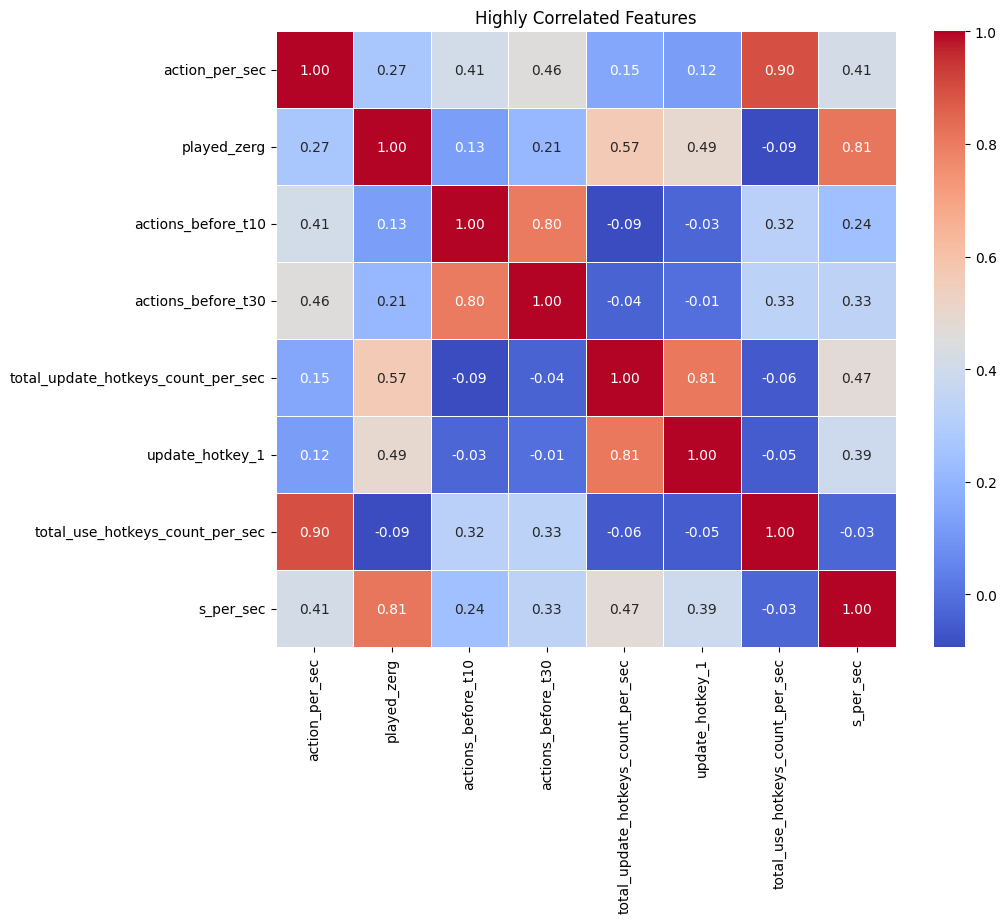

In [ ]:
corr_matrix = model_data.corr()

threshold = 0.75

high_corr_vars = (corr_matrix.abs() > threshold) & (corr_matrix != 1.0)

filtered_corr_matrix = corr_matrix.loc[
    high_corr_vars.any(axis=1), high_corr_vars.any(axis=0)
]

plt.figure(figsize=(10, 8))
sns.heatmap(
    filtered_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
)

plt.title("Highly Correlated Features")
plt.show()

Saving the processed dataframe into a CSV file, because preprocessing takes time. Used for later use (training especially).


In [20]:
from datetime import datetime

model_data.to_csv(
    f"../csv/new_features_{datetime.now().strftime('%Y-%m-%d_%H-%M')}.csv", index=False
)

# Train Model


In [169]:
df = pd.read_csv("../csv/new_features_2025-01-27_14-19.csv")
df = df.dropna()
df.tail(3)

,battleneturl,max_t_value,action_per_sec,played_protoss,played_terran,played_zerg,actions_before_t5,actions_before_t10,actions_before_t30,max_actions_between_t,...,use_hotkey_4,use_hotkey_5,use_hotkey_6,use_hotkey_7,use_hotkey_8,use_hotkey_9,use_hotkey_0,s_per_sec,base_per_sec,mineral_per_sec
3021,http://xx.battle.net/sc2/en/profile/405/1/MMA/,1170.0,2.811966,0,1,0,12,25,79,28,...,0.528205,0.249573,0.010256,0.000000,0.0,0.0,0.059829,0.769231,0.0,0.004274
3022,http://xx.battle.net/sc2/en/profile/410/1/STBo...,580.0,4.239655,0,1,0,22,52,180,43,...,0.181034,0.077586,0.063793,0.027586,0.0,0.0,0.000000,0.779310,0.0,0.072414
3023,http://xx.battle.net/sc2/en/profile/405/1/MMA/,585.0,2.791453,0,1,0,13,30,79,29,...,0.637607,0.114530,0.022222,0.000000,0.0,0.0,0.000000,0.678632,0.0,0.003419


In [170]:
from sklearn.model_selection import train_test_split

X = df.drop(["battleneturl"], axis=1)
y = df["battleneturl"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# param_grid = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [10, 20, 30],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "max_features": ["sqrt", "log2"],
# }

# rf_model = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(
#     estimator=rf_model, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1
# )

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=30,
    max_features="log2",
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, max_features='log2', n_estimators=300,
                       random_state=42)

In [172]:
from sklearn.metrics import classification_report

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

                                                             precision    recall  f1-score   support

      http://eu.battle.net/sc2/en/profile/1021189/1/Dayshi/     1.0000    1.0000    1.0000         4
 http://eu.battle.net/sc2/en/profile/1058669/1/EmpireHappy/     1.0000    0.5000    0.6667         2
       http://eu.battle.net/sc2/en/profile/1058669/1/Happy/     0.7500    1.0000    0.8571         3
  http://eu.battle.net/sc2/en/profile/1139573/1/BabyKnight/     1.0000    1.0000    1.0000         5
    http://eu.battle.net/sc2/en/profile/1143713/1/uThermal/     1.0000    1.0000    1.0000         3
http://eu.battle.net/sc2/en/profile/1173786/1/VPbenQsLivko/     1.0000    1.0000    1.0000         2
    http://eu.battle.net/sc2/en/profile/1430346/1/ShoWTimE/     1.0000    1.0000    1.0000         2
     http://eu.battle.net/sc2/en/profile/2048063/1/AcerBly/     1.0000    1.0000    1.0000         3
    http://eu.battle.net/sc2/en/profile/2101268/1/Stephano/     1.0000    1.0000    1.0000

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

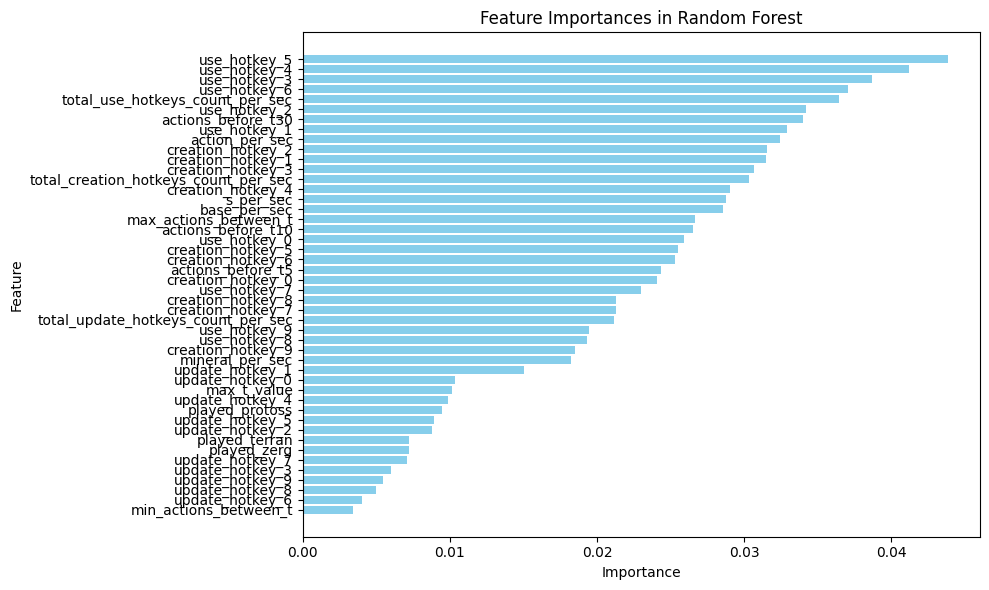

In [173]:
feature_names = (
    X_train.columns
    if hasattr(X_train, "columns")
    else [f"Feature {i}" for i in range(X_train.shape[1])]
)

feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
)

importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances in Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Subset Retrain


In [161]:
# top_n = 40
# selected_features = importance_df.head(top_n)["Feature"].tolist()
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

features_to_remove = [
    # "min_actions_between_t",
    # "update_hotkey_6",
    # "update_hotkey_8",
    "update_hotkey_7",
    "played_terran",
    # "played_protoss",
    # "played_zerg",
    "mineral_per_sec",
]
selected_features = [
    feature for feature in X_train.columns if feature not in features_to_remove
]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

rf_model_retrained = RandomForestClassifier(
    random_state=42,
    max_depth=30,
    max_features="log2",
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
)

rf_model_retrained.fit(X_train_selected, y_train)

y_pred_retrained = rf_model_retrained.predict(X_test_selected)
print(classification_report(y_test, y_pred_retrained, digits=4))

                                                             precision    recall  f1-score   support

      http://eu.battle.net/sc2/en/profile/1021189/1/Dayshi/     1.0000    1.0000    1.0000         4
 http://eu.battle.net/sc2/en/profile/1058669/1/EmpireHappy/     1.0000    0.5000    0.6667         2
       http://eu.battle.net/sc2/en/profile/1058669/1/Happy/     0.7500    1.0000    0.8571         3
  http://eu.battle.net/sc2/en/profile/1139573/1/BabyKnight/     1.0000    1.0000    1.0000         5
    http://eu.battle.net/sc2/en/profile/1143713/1/uThermal/     1.0000    1.0000    1.0000         3
http://eu.battle.net/sc2/en/profile/1173786/1/VPbenQsLivko/     1.0000    1.0000    1.0000         2
    http://eu.battle.net/sc2/en/profile/1430346/1/ShoWTimE/     1.0000    1.0000    1.0000         2
     http://eu.battle.net/sc2/en/profile/2048063/1/AcerBly/     1.0000    1.0000    1.0000         3
    http://eu.battle.net/sc2/en/profile/2101268/1/Stephano/     1.0000    1.0000    1.0000

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [165]:
from itertools import combinations


def evaluate_feature_subset(features_to_keep):
    X_train_selected = X_train[features_to_keep]
    X_test_selected = X_test[features_to_keep]

    rf_model = RandomForestClassifier(
        random_state=42,
        max_depth=30,
        max_features="log2",
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=300,
    )
    rf_model.fit(X_train_selected, y_train)

    y_pred = rf_model.predict(X_test_selected)

    report = classification_report(y_test, y_pred, output_dict=True, digits=4)
    return report["macro avg"]["f1-score"]


best_f1_score = 0
best_subset = None

all_features = X_train.columns.tolist()

for i in range(1, len(all_features) + 1):
    print(f"Testing subsets of size {len(all_features) - i}...")
    for subset in combinations(all_features, len(all_features) - i):
        f1_score = evaluate_feature_subset(list(subset))

        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_subset = subset

print(f"Best F1-score: {best_f1_score:.4f}")
print(f"Best subset of features: {best_subset}")


Testing subsets of size 45...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Testing subsets of size 44...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

KeyboardInterrupt: 

In [164]:
X_train_selected = X_train[list(best_subset)]
X_test_selected = X_test[list(best_subset)]

rf_model_retrained = RandomForestClassifier(
    random_state=42,
    max_depth=30,
    max_features="log2",
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
)

rf_model_retrained.fit(X_train_selected, y_train)

y_pred_retrained = rf_model_retrained.predict(X_test_selected)
print(classification_report(y_test, y_pred_retrained, digits=4))

                                                             precision    recall  f1-score   support

      http://eu.battle.net/sc2/en/profile/1021189/1/Dayshi/     1.0000    1.0000    1.0000         4
 http://eu.battle.net/sc2/en/profile/1058669/1/EmpireHappy/     1.0000    0.5000    0.6667         2
       http://eu.battle.net/sc2/en/profile/1058669/1/Happy/     0.7500    1.0000    0.8571         3
  http://eu.battle.net/sc2/en/profile/1139573/1/BabyKnight/     1.0000    1.0000    1.0000         5
    http://eu.battle.net/sc2/en/profile/1143713/1/uThermal/     1.0000    1.0000    1.0000         3
http://eu.battle.net/sc2/en/profile/1173786/1/VPbenQsLivko/     1.0000    1.0000    1.0000         2
    http://eu.battle.net/sc2/en/profile/1430346/1/ShoWTimE/     1.0000    1.0000    1.0000         2
     http://eu.battle.net/sc2/en/profile/2048063/1/AcerBly/     1.0000    1.0000    1.0000         3
    http://eu.battle.net/sc2/en/profile/2101268/1/Stephano/     1.0000    1.0000    1.0000

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# Test


## Create Test File


In [174]:
features_test = read_ds_gzip(
    Path(os.path.abspath("../in-star-craft-2-player")) / "TEST.CSV.GZ",
    ds="TEST",
)

features_test.tail(3)

,played_race,0,1,2,3,4,5,6,7,8,...,6807,6808,6809,6810,6811,6812,6813,6814,6815,6816
337,Terran,s,s,hotkey10,s,hotkey20,s,s,hotkey12,hotkey22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338,Terran,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,hotkey50,hotkey60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,Terran,s,s,hotkey10,s,hotkey20,s,s,hotkey12,hotkey22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
features_test["first_nan_index"] = features_test.apply(first_nan_occurrence, axis=1)
features_test["max_t_value"] = features_test.apply(max_t_value, axis=1)

features_test["first_nan_index"] = pd.to_numeric(
    features_test["first_nan_index"], errors="coerce"
)

features_test["action_per_sec"] = (
    features_test["first_nan_index"] / features_test["max_t_value"]
)

In [176]:
features_test["played_protoss"] = (features_test["played_race"] == "Protoss").astype(
    int
)
features_test["played_terran"] = (features_test["played_race"] == "Terran").astype(int)
features_test["played_zerg"] = (features_test["played_race"] == "Zerg").astype(int)

features_test = features_test.drop(columns=["played_race"])

In [177]:
patterns = {
    "total_creation_hotkeys_count_per_sec": r"hotkey\d+0",
    "creation_hotkey_1": r"hotkey10",
    "creation_hotkey_2": r"hotkey20",
    "creation_hotkey_3": r"hotkey30",
    "creation_hotkey_4": r"hotkey40",
    "creation_hotkey_5": r"hotkey50",
    "creation_hotkey_6": r"hotkey60",
    "creation_hotkey_7": r"hotkey70",
    "creation_hotkey_8": r"hotkey80",
    "creation_hotkey_9": r"hotkey90",
    "creation_hotkey_0": r"hotkey00",
    "total_update_hotkeys_count_per_sec": r"hotkey\d+1",
    "update_hotkey_1": r"hotkey11",
    "update_hotkey_2": r"hotkey21",
    "update_hotkey_3": r"hotkey31",
    "update_hotkey_4": r"hotkey41",
    "update_hotkey_5": r"hotkey51",
    "update_hotkey_6": r"hotkey61",
    "update_hotkey_7": r"hotkey71",
    "update_hotkey_8": r"hotkey81",
    "update_hotkey_9": r"hotkey91",
    "update_hotkey_0": r"hotkey01",
    "total_use_hotkeys_count_per_sec": r"hotkey\d+2",
    "use_hotkey_1": r"hotkey12",
    "use_hotkey_2": r"hotkey22",
    "use_hotkey_3": r"hotkey32",
    "use_hotkey_4": r"hotkey42",
    "use_hotkey_5": r"hotkey52",
    "use_hotkey_6": r"hotkey62",
    "use_hotkey_7": r"hotkey72",
    "use_hotkey_8": r"hotkey82",
    "use_hotkey_9": r"hotkey92",
    "use_hotkey_0": r"hotkey02",
    "s_per_sec": r"\bs\b",
    "base_per_sec": r"\bBase\b",
    "mineral_per_sec": r"\SingleMineral\b",
}

for column, pattern in patterns.items():
    features_test[column] = features_test.apply(
        lambda row: count_hotkeys(row, pattern), axis=1
    )

features_test.tail(3)


,0,1,2,3,4,5,6,7,8,9,...,use_hotkey_4,use_hotkey_5,use_hotkey_6,use_hotkey_7,use_hotkey_8,use_hotkey_9,use_hotkey_0,s_per_sec,base_per_sec,mineral_per_sec
337,s,s,hotkey10,s,hotkey20,s,s,hotkey12,hotkey22,s,...,0.164000,0.077333,0.072000,0.010667,0.000000,0.0,0.0,0.549333,0.0,0.036000
338,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,hotkey50,hotkey60,hotkey70,...,0.646667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.493333,0.0,0.003333
339,s,s,hotkey10,s,hotkey20,s,s,hotkey12,hotkey22,hotkey12,...,0.221591,0.098864,0.115909,0.037500,0.001136,0.0,0.0,0.694318,0.0,0.048864


In [178]:
features_test["actions_before_t5"] = features_test.iloc[:, 1:].apply(
    lambda x: count_actions_before_t(x, "t5"), axis=1
)

features_test["actions_before_t10"] = features_test.iloc[:, 1:].apply(
    lambda x: count_actions_before_t(x, "t10"), axis=1
)

features_test["actions_before_t30"] = features_test.iloc[:, 1:].apply(
    lambda x: count_actions_before_t(x, "t30"), axis=1
)


features_test["max_actions_between_t"] = features_test.iloc[:, 1:].apply(
    max_actions_between_t, axis=1
)

features_test["min_actions_between_t"] = features_test.iloc[:, 1:].apply(
    min_actions_between_t, axis=1
)

features_test.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,use_hotkey_9,use_hotkey_0,s_per_sec,base_per_sec,mineral_per_sec,actions_before_t5,actions_before_t10,actions_before_t30,max_actions_between_t,min_actions_between_t
337,s,s,hotkey10,s,hotkey20,s,s,hotkey12,hotkey22,s,...,0.0,0.0,0.549333,0.0,0.036000,15,41,160,43,0
338,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,hotkey50,hotkey60,hotkey70,...,0.0,0.0,0.493333,0.0,0.003333,10,18,43,25,1
339,s,s,hotkey10,s,hotkey20,s,s,hotkey12,hotkey22,hotkey12,...,0.0,0.0,0.694318,0.0,0.048864,15,45,158,42,1


In [179]:
patterns = list(patterns)

model_data_test = features_test[
    [
        "max_t_value",
        "action_per_sec",
        "played_protoss",
        "played_terran",
        "played_zerg",
        "actions_before_t5",
        "actions_before_t10",
        "actions_before_t30",
        "max_actions_between_t",
        "min_actions_between_t",
    ]
    + patterns
]

model_data_test.tail(3)

,max_t_value,action_per_sec,played_protoss,played_terran,played_zerg,actions_before_t5,actions_before_t10,actions_before_t30,max_actions_between_t,min_actions_between_t,...,use_hotkey_4,use_hotkey_5,use_hotkey_6,use_hotkey_7,use_hotkey_8,use_hotkey_9,use_hotkey_0,s_per_sec,base_per_sec,mineral_per_sec
337,750.0,2.940000,0,1,0,15,41,160,43,0,...,0.164000,0.077333,0.072000,0.010667,0.000000,0.0,0.0,0.549333,0.0,0.036000
338,300.0,2.440000,0,1,0,10,18,43,25,1,...,0.646667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.493333,0.0,0.003333
339,880.0,3.382955,0,1,0,15,45,158,42,1,...,0.221591,0.098864,0.115909,0.037500,0.001136,0.0,0.0,0.694318,0.0,0.048864


In [132]:
model_data_test = model_data_test[list(best_subset)]

In [180]:
model_data_test.to_csv(
    f"../csv/test_data_{datetime.now().strftime('%Y-%m-%d_%H-%M')}.csv", index=False
)

## Create Submission File


In [182]:
test_data = pd.read_csv("../csv/test_data_2025-01-27_17-16.csv")

test_data = test_data.fillna(0)
y_pred_test = rf_model.predict(test_data)
# y_pred_test = rf_model_retrained.predict(test_data)

In [183]:
submit_file = pd.read_csv("../in-star-craft-2-player/SAMPLE_SUBMISSION.CSV")

submit_file["prediction"] = y_pred_test

submit_file["prediction"].value_counts()

http://kr.battle.net/sc2/en/profile/2348639/1/ParalyzE/      6
http://kr.battle.net/sc2/en/profile/2342419/1/soO/           6
http://kr.battle.net/sc2/en/profile/2341467/1/Classic/       6
http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/      5
http://kr.battle.net/sc2/en/profile/2332264/1/Zest/          5
                                                            ..
http://kr.battle.net/sc2/en/profile/2344407/1/Ragnarok/      1
http://us.battle.net/sc2/en/profile/5068246/1/yoeFWSlam/     1
http://us.battle.net/sc2/en/profile/4609532/1/aLive/         1
http://us.battle.net/sc2/en/profile/3948354/1/hendralisk/    1
http://xx.battle.net/sc2/en/profile/405/1/MMA/               1
Name: prediction, Length: 174, dtype: int64

In [184]:
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M")

file_name = f"../submit_files/updated_submit_file_{timestamp}_rf.csv"

submit_file.to_csv(file_name, index=False)

In [185]:
high_score = pd.read_csv("../submit_files/updated_submit_file_2025-01-27_15-03_rf.csv")

In [186]:
submit_file.sort_values("RowId", inplace=True)
high_score.sort_values("RowId", inplace=True)

comparison = submit_file.merge(
    high_score, on="RowId", suffixes=("_submit_file", "_high_score"), how="outer"
)

for _, row in comparison.iterrows():
    row_id = row["RowId"]
    pred_file1 = row.get("prediction_submit_file", "<MISSING>")
    pred_file2 = row.get("prediction_high_score", "<MISSING>")

    if pred_file1 == pred_file2:
        # print(
        #     f"Row {row_id} | submit_file {pred_file1.split('profile/')[1]} | high_score: {pred_file2.split('profile/')[1]}"
        # )
        pass
    else:
        print(
            f"Row {row_id} | submit_file {pred_file1.split('profile/')[1]} | high_score: {pred_file2.split('profile/')[1]}"
            # f"Row {row_id} | submit_file {pred_file1} | high_score: {pred_file2}"
        )

Row 39 | submit_file 4167590/1/AxHeart/ | high_score: 2240191/1/Heart/
Row 59 | submit_file 5142993/1/Bomber/ | high_score: 3985949/1/Bomber/
Row 62 | submit_file 2575821/1/HuK/ | high_score: 2575821/1/HuKRC/
Row 69 | submit_file 4174681/1/AxAlicia/ | high_score: 4085747/1/Alicia/
Row 158 | submit_file 1058669/1/Happy/ | high_score: 1058669/1/EmpireHappy/
Row 159 | submit_file 2344476/1/Dark/ | high_score: 902213/1/Suppy/
Row 185 | submit_file 5087767/1/OzOz/ | high_score: 3886231/1/OzOz/
Row 197 | submit_file 415/1/EGJD/ | high_score: 902213/1/Suppy/
Row 207 | submit_file 4863808/1/Bomber/ | high_score: 5142993/1/Bomber/
Row 213 | submit_file 3301677/1/CMRevival/ | high_score: 3311551/1/CMRevival/
Row 214 | submit_file 4085747/1/Alicia/ | high_score: 4174681/1/AxAlicia/
Row 215 | submit_file 2553612/1/puCK/ | high_score: 3585588/1/llllllllll/
Row 220 | submit_file 2821952/1/KingkOng/ | high_score: 2341920/1/CoCa/
Row 232 | submit_file 4863808/1/Bomber/ | high_score: 5142993/1/Bomber/


In [167]:
best_subset_87_61 = (
    "max_t_value",
    "action_per_sec",
    "played_protoss",
    "played_terran",
    "played_zerg",
    "actions_before_t5",
    "actions_before_t10",
    "actions_before_t30",
    "max_actions_between_t",
    "min_actions_between_t",
    "total_creation_hotkeys_count_per_sec",
    "creation_hotkey_1",
    "creation_hotkey_2",
    "creation_hotkey_3",
    "creation_hotkey_4",
    "creation_hotkey_5",
    "creation_hotkey_6",
    "creation_hotkey_7",
    "creation_hotkey_8",
    "creation_hotkey_9",
    "creation_hotkey_0",
    "total_update_hotkeys_count_per_sec",
    "update_hotkey_1",
    "update_hotkey_2",
    "update_hotkey_3",
    "update_hotkey_4",
    "update_hotkey_5",
    "update_hotkey_6",
    "update_hotkey_7",
    "update_hotkey_8",
    "update_hotkey_0",
    "total_use_hotkeys_count_per_sec",
    "use_hotkey_1",
    "use_hotkey_2",
    "use_hotkey_3",
    "use_hotkey_4",
    "use_hotkey_5",
    "use_hotkey_6",
    "use_hotkey_7",
    "use_hotkey_8",
    "use_hotkey_9",
    "use_hotkey_0",
    "s_per_sec",
    "base_per_sec",
    "mineral_per_sec",
)

In [168]:
len(best_subset_87_61)

45